## Set up

### Set up for Colab

In [3]:
# For runing notebook in colab
from google.colab import drive
drive.mount('/content/drive')
import os
root_of_repository = '/content/drive/MyDrive/ADL/Project/'
os.chdir(root_of_repository)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Packages

In [3]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

import numpy as np
import pandas as pd
import json
import copy
import time
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

In [5]:
LABEL_DICT = {'fear':0, 'neutral':1, 'sad':2, 'surprise':3, 'angry':4, 'happy':5} # Mapping label code and meaning
DEVELOPMENT_SET_PATH = 'data/usual_train.txt'
TEST_SET_PATH = 'data/usual_test_labeled.txt'

In [6]:
with open(DEVELOPMENT_SET_PATH, encoding='utf8') as file:
    dev_set = json.load(file)
    train_set, val_set = train_test_split(dev_set, test_size=0.2, random_state=4995)

with open(TEST_SET_PATH, encoding='utf8') as file:
    test_set = json.load(file)

In [26]:
data = pd.concat([
    pd.DataFrame(train_set).assign(Type='Train Set'),
    pd.DataFrame(val_set).assign(Type='Validation Set'),
    pd.DataFrame(test_set).assign(Type='Test Set')],
    axis=0).reset_index(drop=True)
data['n_words'] = data.content.str.len()

In [44]:
data.to_excel('result/data/clean_dataset.xlsx', index=False)

In [27]:
data_agg = data.groupby(['Type', 'label'], as_index=False) \
    .agg(size = ('Type', 'count'),
         total_words = ('n_words', 'sum')) \
    .sort_values(['Type', 'size'], ascending=False)
data_agg

,Type,label,size,total_words
12,Validation Set,angry,1650,69793
15,Validation Set,neutral,1119,44273
14,Validation Set,happy,1070,51473
16,Validation Set,sad,1004,42076
17,Validation Set,surprise,444,14788
13,Validation Set,fear,267,17050
6,Train Set,angry,6694,275855
9,Train Set,neutral,4630,188510
8,Train Set,happy,4309,195225
10,Train Set,sad,3986,168826


In [43]:
data_agg.groupby(['Type'], as_index=False) \
     .agg(total_sentences = ('size', 'sum'),
          total_words = ('total_words', 'sum')) \
     .assign(ratio=lambda x: x['total_sentences'] / x['total_sentences'].sum()) \
     .assign(avg_word=lambda x: x['total_words'] / x['total_sentences']) \
     

,Type,total_sentences,total_words,ratio,avg_word
0,Test Set,5000,213799,0.152588,42.759800
1,Train Set,22214,949571,0.677917,42.746511
2,Validation Set,5554,239453,0.169495,43.113612


6        angry
9      neutral
8        happy
10         sad
11    surprise
7         fear
Name: label, dtype: object


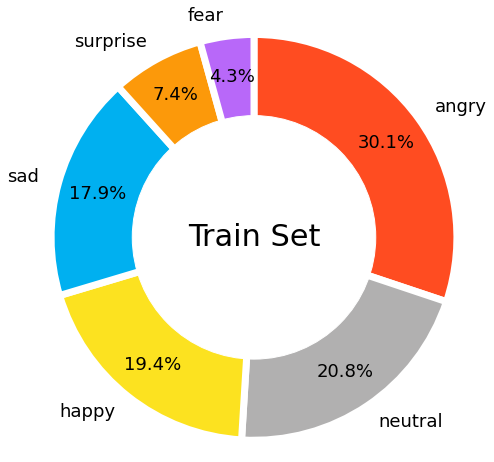

12       angry
15     neutral
14       happy
16         sad
17    surprise
13        fear
Name: label, dtype: object


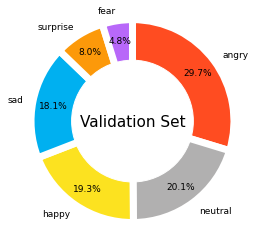

0       angry
2       happy
3     neutral
4         sad
5    surprise
1        fear
Name: label, dtype: object


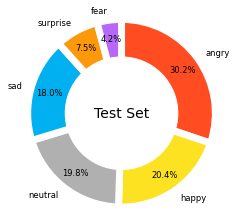

In [19]:
for data_type, figure_size in [
    ('Train Set', 8),
    ('Validation Set', 4),
    ('Test Set', 3.7)
]:
    fig, ax = plt.subplots(figsize=(figure_size, figure_size))
    # The slices will be ordered and plotted counter-clockwise.

    plot_data = data_agg.query(f"Type == '{data_type}'")
    
    COLOR_PALLETE = {
        'happy': '#FCE220',
        'sad': '#00B0F0',
        'surprise': '#FC990A',
        'fear': '#b868f9',
        'neutral': '#b1b0b0',
        'angry': '#FF4C21'
    }
    print( plot_data['label'])
    colors = [COLOR_PALLETE[label] for label in plot_data['label']] #define colors of three donut pieces
    explode = (0, 0, 0, 0, 0, 0) # explode a slice if required
    textprops = {'fontsize':2.25 * figure_size, 'color':'black'} # Font size of text in donut chart

    plt.pie(plot_data['size'], explode=explode, labels=plot_data['label'], colors=colors,
            counterclock=False,
            autopct='%.1f%%', # Show data in 0.00%
            pctdistance = 0.8,
            startangle=-270,
            shadow=False,
            textprops =textprops,
            wedgeprops={'linewidth': 7.0, 'edgecolor': 'white'},)
    
    #draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0,0), 0.6,color='white', fc='white',linewidth=1.00)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.axis('equal') # Set aspect ratio to be equal so that pie is      drawn as a circle.
    plt.text(.5, .5, data_type, size=figure_size * 3.8, transform = ax.transAxes, ha='center', va='center') 
    plt.savefig(f'output/data_pie_chart_{data_type}.png', dpi=450)
    plt.show()